In [35]:
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np

# Expanded Targetome 

This is a currently unpublished expanded targetome dataset that we are experimenting with, there are plans to release this data publicly in the future. 

In [7]:
# CONFIG 
THRESHOLD_uM = 10

In [11]:

targ2 = pd.read_csv('../../../data/targetome_extended-01-23-25.csv')
druginfo = pd.read_csv('../../../data/compoundinfo_beta.txt', sep='\t')
tinfo = pd.read_csv('../../../data/targetome_extended_drugs-01-23-25.csv')

targ2.head() 

/tmp/ipykernel_28857/170753740.py:3: DtypeWarning: Columns (10,11,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  tinfo = pd.read_csv('../../../data/targetome_extended_drugs-01-23-25.csv')


,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value
0,6,VYZAHLCBVHPDDF-UHFFFAOYSA-N,P78417,29652143.0,pubchem_bioassay,IC50,=,900000.0
1,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P0DMS8,19282184.0,pubchem_bioassay,Ki,>,100000.0
2,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29274,19282184.0,pubchem_bioassay,Ki,=,2200.0
3,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P29275,19282184.0,pubchem_bioassay,Ki,>,30000.0
4,7,MUIPLRMGAXZWSQ-UHFFFAOYSA-N,P30542,19282184.0,pubchem_bioassay,Ki,=,7400.0


In [31]:
targ2dep = targ2.merge(druginfo[['pert_id', 'inchi_key']].drop_duplicates(), on='inchi_key', how='inner')
targ2dep = targ2dep[lambda x: x.assay_relation == '=']
targ2dep = targ2dep.groupby(['pert_id', 'uniprot_id', 'inchi_key'])[['assay_value']].mean().reset_index()
targ2dep = targ2dep.assign(binding = lambda x: x.assay_value <= THRESHOLD_uM)
targ2dep = targ2dep[lambda x: x.binding]
targ2dep.head()

,pert_id,uniprot_id,inchi_key,assay_value,binding
9,BRD-A00546892,P08912,YSXKPIUOCJLQIE-UHFFFAOYSA-N,6.300000,True
10,BRD-A00546892,P11229,YSXKPIUOCJLQIE-UHFFFAOYSA-N,1.420000,True
11,BRD-A00546892,P20309,YSXKPIUOCJLQIE-UHFFFAOYSA-N,4.925000,True
13,BRD-A00993607,P07550,PAZJSJFMUHDSTF-UHFFFAOYSA-N,9.237105,True
14,BRD-A00993607,P08588,PAZJSJFMUHDSTF-UHFFFAOYSA-N,7.003600,True


In [32]:
print('# of unique drugs:', targ2dep.inchi_key.nunique())
print('# of unique targets:', targ2dep.uniprot_id.nunique())
print('# of unique DTIs :', targ2dep[['inchi_key', 'uniprot_id']].drop_duplicates().shape[0])

# of unique drugs: 920
# of unique targets: 688
# of unique DTIs : 2067


In [33]:
tinfo2 = tinfo[['inchi_key', 'atc']].drop_duplicates() 
tinfo2 = tinfo2.assign(atc_inhibitor = lambda x: x.atc.str.contains('inhibitor'))
tinfo2 = tinfo2.assign(atc_agonist = lambda x: x.atc.str.contains('agonist'))

targ2dep = targ2dep.merge(tinfo2[['inchi_key', 'atc_agonist', 'atc_inhibitor']], on='inchi_key', how='left')

print(f'# of inhibitors: {targ2dep.atc_inhibitor.sum()}')
print(f'# of agonists: {targ2dep.atc_agonist.sum()}')

targ2dep.head() 

# of inhibitors: 223
# of agonists: 304


,pert_id,uniprot_id,inchi_key,assay_value,binding,atc_agonist,atc_inhibitor
0,BRD-A00546892,P08912,YSXKPIUOCJLQIE-UHFFFAOYSA-N,6.300000,True,True,False
1,BRD-A00546892,P11229,YSXKPIUOCJLQIE-UHFFFAOYSA-N,1.420000,True,True,False
2,BRD-A00546892,P20309,YSXKPIUOCJLQIE-UHFFFAOYSA-N,4.925000,True,True,False
3,BRD-A00993607,P07550,PAZJSJFMUHDSTF-UHFFFAOYSA-N,9.237105,True,True,False
4,BRD-A00993607,P08588,PAZJSJFMUHDSTF-UHFFFAOYSA-N,7.003600,True,True,False


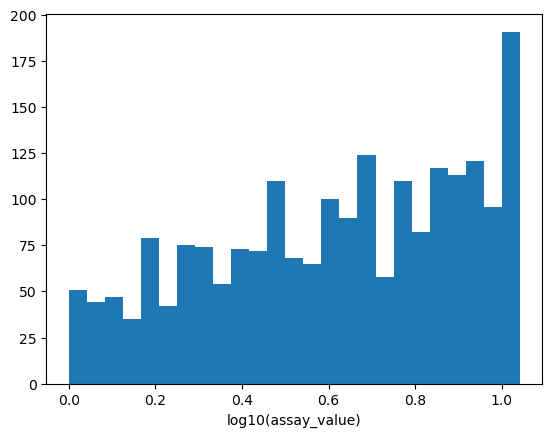

In [40]:
plt.figure() 
plt.hist(np.log10(targ2dep.assay_value + 1), bins=25)
plt.xlabel('log10(assay_value)')
plt.show()

In [41]:
targ2dep.to_csv('../../extdata/targetome_expanded_beta.csv', index=False)